### Import all Packages ###

In [18]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import collections
import nest_asyncio
%reload_ext tensorboard
nest_asyncio.apply()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

### Load in TFF - EMNIST Data Set ###

In [19]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)

### Create a Server Class ###

In [33]:
class server:
    
    def __init__(self, numOfClients):
        self.numOfClients = numOfClients #Num of Client
        self.clientIds = list(range(0,self.numOfClients)) #Client List
        self.updateRoundNum = 0  # Update Round Number
        self.serverModel = self.createBaseModel() #Create a Keras Model for MNIST
        self.clientActive = [] #If client is available or not based on time - day/night
        self.clientCIF = []
        self.clientSelected = []
        self.maxClientsPerRound = 5
        self.updateFromClients=[]
        self.__serverTestData_X=[]
        self.__serverTestData_Y=[]
        self.__serverTestData = self.setServerTestDataTFF(emnist_test)
        self.predictionAcc=[]
        self.predictionLoss=[]
        self.__serverTrainData = self.setServerTrainDataTFF(emnist_train)
        self.roundClients = []
        
        
    def createBaseModel(self):
        #return tf.keras.models.Sequential([
        #    Dense(64, activation='relu',input_shape=(784,)),
        #    Dense(64, activation='relu'),
        #    Dense(10, activation='softmax'),])
        return tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(784,)),
            tf.keras.layers.Dense(10, kernel_initializer='zeros'),
            tf.keras.layers.Softmax()])
    
    def setServerTestData(self,Xtest,Ytest):  # NOT USED IN THIS CASE
        self.__serverTestData_X=Xtest
        self.__serverTestData_Y=Ytest
        
    def setServerTestDataTFF(self,serverTestData):  #Creates a test set for server
        BATCH_SIZE = 1000
        SHUFFLE_BUFFER = 100
        PREFETCH_BUFFER= 10

        def preprocess(dataset):
            def batch_format_fn(element):
                """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
                return collections.OrderedDict(
                    x=tf.reshape(element['pixels'], [-1, 784]),
                    y=tf.reshape(element['label'], [-1, 1]))

            return dataset.repeat(10).shuffle(SHUFFLE_BUFFER).batch(
              BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
        
        serverData1 = serverTestData.create_tf_dataset_for_client(serverTestData.client_ids[10])
        for i in range (80,500):
            serverData1 = serverData1.concatenate(serverTestData.create_tf_dataset_for_client(serverTestData.client_ids[i]))
            
        serverData =tfds.as_numpy(preprocess(serverData1))
        return serverData
     
    def setServerTrainDataTFF(self,serverTrainData):  
        #Creates a train set for server -- used for general only server training case i.e. no client all data trained on server
        # and for pre-training case evaluation i.e pre-trained model distributed to clients instead of random initializing
        #uses the emnist train dataset instead of the test data set
        
        BATCH_SIZE = 100
        SHUFFLE_BUFFER = 100
        PREFETCH_BUFFER= 10

        def preprocess(dataset):
            def batch_format_fn(element):
                """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
                return collections.OrderedDict(
                    x=tf.reshape(element['pixels'], [-1, 784]),
                    y=tf.reshape(element['label'], [-1, 1]))

            return dataset.repeat(50).shuffle(SHUFFLE_BUFFER).batch(
              BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
        
        serverData2 = serverTrainData.create_tf_dataset_for_client(serverTrainData.client_ids[1])
        for i in range (2000,2500):
            serverData2 = serverData2.concatenate(serverTrainData.create_tf_dataset_for_client(serverTrainData.client_ids[i]))
            
        serverData =tfds.as_numpy(preprocess(serverData2))
        return serverData
    
    def initialBroadcast(self):
        for i in self.clientIds:
            clientName = client_list["client_"+str(self.clientIds[i])]  #Create Client Name, Using Client_List Dictionary
            #clientName = "client_"+str(self.clientIds[i])  #Create Client Name
            #print(clientName)
            clientName.setInitialModel(self.serverModel) #setInitialModel-> Method of client Class
            #eval(clientName).setInitialModel(self.serverModel) #setInitialModel-> Method of client Class
            
    def getClientActiveStatus(self):  #if the client is available for update or not randomly set in client
        print("--------------------------------------------\n","Round NO:",self.updateRoundNum)
        self.clientActive = []
        for i in self.clientIds:
            clientName = client_list["client_"+str(self.clientIds[i])]  #Create Client Name
            #print(clientName)
            if(clientName.sendActiveStatus() == 1): #getActiveStatus() -> method of client class
                self.clientActive.append(i)
        #print("Active Clients in Round :--: ", self.clientActive)
    
    
    def getClientCIF(self): # Get Client Importance Factor for active clients
        self.clientCIF=[]
        for i in self.clientActive:
            clientName = client_list["client_"+str(i)]
            c_cif = clientName.sendCIF()   #sendCIF() - method of client
            self.clientCIF.append(c_cif)
        #print("Clients with Acceptable CIF: ", self.clientCIF)
        
    def getClientSelected(self): # Select The Top (N = maxClientsPerRound) with the highest CIF value
        self.clientSelected = []
        # Use non-class, local variables to leave class variables clean
        clientCIF, clientActive = ( list(t) for t in zip(*sorted(zip(self.clientCIF, self.clientActive)))) # Sort Active Clients and their CIF values, by CIF
        self.clientSelected  = clientActive[-self.maxClientsPerRound:] # Select the N=maxClientsPerRound of clients with highest CIF
        self.clientCIF = clientCIF[-self.maxClientsPerRound:] # Select the N=maxClientsPerRound of highest CIF
        self.roundClients.append(len(self.clientSelected))
        
    def getClientSelectedMaxFrac(self): # Select The Top (N = maxClientsPerRound) with the highest CIF value
        self.clientSelected = []
        # Use non-class, local variables to leave class variables clean
        clientCIF, clientActive = ( list(t) for t in zip(*sorted(zip(self.clientCIF, self.clientActive)))) # Sort Active Clients and their CIF values, by CIF
        maxCIF = clientCIF[-1:][0]
        limitCIF = maxCIF*0.9
        newClientCIF = [i for i in clientCIF if i>limitCIF]
        newSelectedClients = clientActive[-len(newClientCIF):]
        self.clientSelected = newSelectedClients
        self.clientCIF = newClientCIF
        self.roundClients.append(len(self.clientSelected))
        print('RoundMaxCIF:',maxCIF,' ||',end=" ")
        print('RoundLimitCIF:',limitCIF,' ||',end=" ")
        print('numberOfClientSlected:',len(self.clientSelected))       
   
    def getRandomClients(self):
        self.clientSelected = np.random.randint(0, 100, 10)
        self.clientCIF=[]*0
        self.clientActive=[]*0
    
    def getModelUpdateFromClients(self):
        
        #print("Active Clients: ",self.clientActive)
        #print("CIF of Active Clients: ", self.clientCIF)
        print("Selected Clients: ", self.clientSelected)
        #print("Training Clients with CIF > 10")
        self.updateRoundNum +=1
        self.updateFromClients=[]
        #self.dataPointsClients=[]
        
        for i in range (0,len(self.clientSelected)):
            #if self.clientCIF[i] >= 10:  #Select Client only if CIF > some value 10 chosen for testing ONLY
            clientName = client_list["client_"+str(int(self.clientSelected[i]))]
            self.updateFromClients.append(clientName.sendClientUpdate()) #Get a list of updates from selected clients

        avgModelWeights = self.computeFedAvg(self.updateFromClients)
        #print("average model weights = \n",avgModelWeights)
        self.serverModel.set_weights(avgModelWeights)   
        
    def computeFedAvg(self,updates):  #Compute Federated Averaging from Available Clients
        totalDataPoints = 0
        scaleFactor=[]
        for i in range (0,len(updates)):
            totalDataPoints += updates[i][1]   #Sum the total Data Points on All Available Clients
            scaleFactor.append(updates[i][1])  #Store individual number datapoints for clients

        scaleFactor = np.array(scaleFactor)/totalDataPoints #Create the scale factor
       
        sumOfAvgWeights = []*len(updates[0][0]) 
        
        for j in range (0,len(updates[0][0])): #range of layers
            k=np.zeros_like(updates[0][0][j])
            #print("ShapeofK:",k.shape)
            for i in range(0,len(updates)): #range of clients
                k=k+updates[i][0][j]*scaleFactor[i]
                #print("ShapeofK:",k.shape)
            sumOfAvgWeights.append(k)
      
        return sumOfAvgWeights   
    
    def testServerModel(self):
        self.serverModel.compile(loss = 'sparse_categorical_crossentropy',
                                optimizer = tf.keras.optimizers.SGD (learning_rate=.01),
                                metrics=['accuracy'])
        testData = next(iter(self.__serverTestData))
        return self.serverModel.evaluate(testData['x'],
                                         testData['y'],)
        
        
    def updateAllClients(self):
        for i in self.clientIds:
            clientName = client_list["client_"+str(self.clientIds[i])]  #Create Client Name
            clientName.setModelUpdateWeights(self.serverModel.get_weights())
    
    def getDataCost(self):
        totalDataCost=0
        for i in self.clientIds:
            clientName = client_list["client_"+str(self.clientIds[i])]
            totalDataCost += clientName.getDataCost()
        print("Total Data Cost = ",totalDataCost)
        return totalDataCost
    
    def performServerTraining(self):
        trainData = next(iter(self.__serverTrainData))
        self.serverModel.compile(loss = 'sparse_categorical_crossentropy',
                                 optimizer = tf.keras.optimizers.SGD (learning_rate=.01),
                                 metrics=['accuracy'])
        self.serverModel.fit(trainData['x'],
                                       trainData['y'],
                                       epochs=1,
                                       verbose=0,shuffle=True)


### Create a Client Class ###

In [43]:
class client:
    
    def __init__(self,ID):
        self.id = ID
        self.__clientModel = tf.keras.models.Sequential()
        self.__clientModelWeights=[]
        self.activeStatus = 0
        self.__clientDataX=[] #Private to Client
        self.__clientDataY=[]
        self.clientCIF=0
        self.meanSINR = int(np.random.normal(15, 2.5, 1)) #Select random int from normal dist 
        self.roundSINR = 0
        self.propFair = 0
        self.epochs = 10
        self.lr = 0.01
        self.__clientData = self.__clientDataFromTFF(emnist_train)
        self.__currentData = next(iter(self.__clientData))
        self.dataQuality = 0
        self.dataCost = 0
        self.dataCostFactor=0.2
        
        
    def __clientDataFromTFF(self,tffDataset):
        NUM_EPOCHS = self.epochs
        #BATCH_SIZE = 20
        BATCH_SIZE = 50
        SHUFFLE_BUFFER = 100
        PREFETCH_BUFFER= 10

        def preprocess(dataset):
            def batch_format_fn(element):
                """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
                return collections.OrderedDict(
                    x=tf.reshape(element['pixels'], [-1, 784]),
                    y=tf.reshape(element['label'], [-1, 1]))

            return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
              BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
        
        return tfds.as_numpy(preprocess(tffDataset.create_tf_dataset_for_client(tffDataset.client_ids[self.id])))
    
    
    #Methods Private to client
    def __setActiveStatus(self): 
        self.activeStatus = int(np.random.randint(0,2,1))  #01.01.21 Random Client Activation
        #self.activeStatus = 1
    
    def __setRoundSINR(self):
        self.roundSINR = np.round((np.random.normal(self.meanSINR, 1, 1)[0]), 2)
        #print("Round SNR for Client: ",self.id," is: ", self.roundSINR)
                               
    def __setPropFair(self):
        self.propFair = self.roundSINR / self.meanSINR
        
    def __setdataQuality(self):\
        
        ## Calculate for entropy - Start ##
        
#         for values in classification_probabilities:
#           for value in values:
#             score += value * np.log(value)
#         score = score * -1

        ## Calculate for entropy - End ##
        
        #self.dataQuality = 20 # Set 20 so that CIF value will always be passing
        
        # Next Client Data to be called  <<_ NOt written yet
        self.__currentData = next(iter(self.__clientData))
        predictions = self.__clientModel.predict(self.__currentData['x'])  # Get Class Predictions using Predict
        entropy = []*len(predictions)  # Entropy Will hold the entropy scores for all samples in the given round for this round
       
        for i in range (0,len(predictions)):
            sampleClassProb = predictions[i] #Take Class probability for every sample 
            score=0
            for value in sampleClassProb:  # Calculate the score - same as what jonny wrote in the pseudo code above
                #print('Value:',value)
                score += value*np.log2(value)
            score=score*(-1)
            #print('Score:',score)
            entropy.append(score)  # Append the Entropy for the given Sample
        #print('Entropy:',entropy)
        self.dataQuality = max(entropy) #Use the max (entropy) value as the data quality index
        #self.dataQuality = sum(entropy)/len(entropy)
        #print("Data Quality for Client: ",self.id," is: ", self.dataQuality)
        #self.dataQuality = (self.dataQuality-3)*100 #<<- All entropys are 3.something so normalized to get the dec values
        #print("Data Quality for Client: ",self.id," is: ", self.dataQuality)
        
    def __setCIF(self):
        #self.clientCIF = int(np.random.randint(0,50,1))  # Random Number between 0 and 49 for check purpose only
        self.__setRoundSINR()
        self.__setPropFair() #This is currently unused
        self.__setdataQuality()
        #self.clientCIF = self.dataQuality + self.roundSINR 
        self.clientCIF = (-1/self.roundSINR) + self.dataQuality #Formula for computing client CIF
        #self.clientCIF = 20
        #print("CIF for Client: ",self.id," is: ", self.clientCIF)
        
    def __getTrainData(self):
        return self.__clientDataX, self.__clientDataY  # Just for Testing will be expanded to select meaningful data
    
    #Public Methods
    def sendActiveStatus(self):
        self.__setActiveStatus()
        return self.activeStatus
    
    def sendCIF(self):
        self.__setCIF()
        return self.clientCIF
    
    def setInitialModel(self,model):
        self.__clientModel=model
        print(self.__clientModel.summary)
         
    def setClientData(self,X,Y):
        self.__clientDataX = X
        self.__clientDataY = Y
   

    def sendClientUpdate(self):
        self.dataCost += self.dataCostFactor
        print("->",self.id,end=" ")
        self.__clientModel.compile(loss = 'sparse_categorical_crossentropy',
                                optimizer = tf.keras.optimizers.SGD (learning_rate=self.lr),
                                metrics=['accuracy'])
        #print(self.__clientDataX.shape)
        #print(self.__clientDataY.shape)
        if len(self.__clientDataX) > 0:
            history = self.__clientModel.fit(self.__clientDataX,
                                   tf.keras.utils.to_categorical(self.__clientDataY),
                                   epochs=self.epochs,
                                   validation_split=0.2,
                                   verbose=0,
                                    shuffle=True)

            updatedWeights = self.__clientModel.get_weights()
        
        else:
            #currentData = next(iter(self.__clientData))  # <-- Shifted to the setDataQuality Function
            history = self.__clientModel.fit(self.__currentData['x'],
                                   self.__currentData['y'],
                                   epochs=self.epochs,
                                   verbose=0,shuffle=True)
            
            
            
            
            updatedWeights = self.__clientModel.get_weights()
       
        
        numOfDataPoints = len(self.__currentData['x'])   #<-- Set the correct type to get the number of datapoints in the current update round

        return (updatedWeights,numOfDataPoints)
    
    #def logTraningHistory(self,history,roundNumber):
    #    loss_history = history.history["loss"]
    #    acc_history = history.history["accuracy"]
    #    numpy_loss_history = numpy.array(loss_history)
    
    def setModelUpdateWeights(self,modelUpdateWeights):
        self.dataCost += self.dataCostFactor
        self.__clientModel.set_weights(modelUpdateWeights)
        #self.__clientModel.
        
    def plotClientData(self):
        #print("Y_Data",self.__clientDataY)
        id0=[]
        id1=[]
        id2=[]
        id3=[]
        id4=[]
        id5=[]
        id6=[]
        id7=[]
        id8=[]
        id9=[]
        for i in range (0,len(self.__clientData['x'])):
            for j in range (0,10):
                if j==self.__clientData['y']:
                    eval('id'+str(j)).append(i)
        xAxis=['0','1','2','3','4','5','6','7','8','9']
        yAxis=[len(id0),len(id1),len(id2),len(id3),len(id4),len(id5),len(id6),len(id7),len(id8),len(id9)]
        plt.bar(xAxis,yAxis)
        title="Data for Client"+str(self.id)
        plt.title(title)
        plt.show()
    
    def getDataCost(self):
        return self.dataCost

### Initialize Clients ###

In [44]:
client_list = {}

# Set the number of clients
num_clients = 100
for i in range(num_clients):
    name = "client_" + str(i)
    client_list[name] = client(i)

### Initialize Server ###

In [45]:
# Initialize server with number of clients
serverFA = server(num_clients)

### Initial Broadcast from Server to Client ###

In [46]:
serverFA.initialBroadcast()

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002953D39BE88>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002953D39BE88>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002953D39BE88>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002953D39BE88>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002953D39BE88>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002953D39BE88>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002953D39BE88>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002953D39BE88>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequentia

In [47]:
trainingName = "CIF_UE_MaxFrac0.9_C100R50BS50_2" #Name of the current Training Scheme Used for Tensorboard and Saving Results
keys = ['loss','accuracy']
numberOfTraingRounds = 50
serverTestMetrics=[]*numberOfTraingRounds
logdir = "logs/" + trainingName + "/"
summary_writer = tf.summary.create_file_writer(logdir)
with summary_writer.as_default():
    for i in range(0,numberOfTraingRounds):
        serverFA.getClientActiveStatus()
        serverFA.getClientCIF()
        serverFA.getClientSelectedMaxFrac()
        serverFA.getModelUpdateFromClients()
        metrics = serverFA.testServerModel()
        d_metrics = zip(keys,metrics)
        serverTestMetrics.append(metrics)
        serverFA.updateAllClients()
        for name , value in d_metrics:
            tf.summary.scalar(name, value, step=i)


--------------------------------------------
 Round NO: 0
RoundMaxCIF: 3.274489753725859  || RoundLimitCIF: 2.9470407783532733  || numberOfClientSlected: 46
Selected Clients:  [47, 96, 93, 81, 33, 70, 68, 71, 34, 21, 56, 44, 84, 92, 99, 60, 30, 24, 57, 53, 49, 3, 89, 59, 76, 79, 40, 0, 29, 54, 25, 75, 22, 37, 12, 26, 4, 1, 77, 87, 10, 43, 72, 51, 8, 94]
32/32 [==============================] - 0s 1ms/step - loss: 1.6180 - accuracy: 0.7170 99 -> 60 -> 30 -> 24 -> 57 -> 53 -> 49 -> 3 -> 89 -> 59 -> 76 -> 79 -> 40 -> 0 -> 29 -> 54 -> 25 -> 75 -> 22 -> 37 -> 12 -> 26 -> 4 -> 1 -> 77 -> 87 -> 10 -> 43 -> 72 -> 51 -> 8 -> 9
--------------------------------------------
 Round NO: 1
RoundMaxCIF: 3.247171939277438  || RoundLimitCIF: 2.922454745349694  || numberOfClientSlected: 55
Selected Clients:  [27, 95, 57, 40, 42, 64, 16, 33, 14, 20, 90, 43, 55, 5, 10, 2, 23, 7, 32, 80, 97, 98, 70, 25, 38, 61, 91, 19, 85, 22, 30, 71, 0, 35, 47, 24, 89, 92, 48, 74, 87, 39, 63, 67, 52, 28, 54, 46, 45, 31, 94

32/32 [==============================] - 0s 1ms/step - loss: 0.6507 - accuracy: 0.80903 -> 46 -> 22 -> 86 -> 90 -> 84 -> 18 -> 78 -> 87 -> 2
--------------------------------------------
 Round NO: 17
RoundMaxCIF: 2.9362160438838387  || RoundLimitCIF: 2.642594439495455  || numberOfClientSlected: 21
Selected Clients:  [47, 24, 9, 71, 30, 38, 65, 50, 53, 34, 41, 0, 86, 1, 68, 70, 22, 87, 84, 46, 54]
32/32 [==============================] - 0s 1ms/step - loss: 0.6244 - accuracy: 0.8140 -> 70 -> 22 -> 87 -> 84 -> 46 -> 5
--------------------------------------------
 Round NO: 18
RoundMaxCIF: 3.0221058266398346  || RoundLimitCIF: 2.7198952439758513  || numberOfClientSlected: 20
Selected Clients:  [52, 44, 85, 21, 41, 62, 39, 60, 0, 45, 73, 33, 77, 70, 71, 50, 63, 20, 15, 90]
32/32 [==============================] - 0s 1ms/step - loss: 0.6212 - accuracy: 0.816071 -> 50 -> 63 -> 20 -> 15 -> 9
--------------------------------------------
 Round NO: 19
RoundMaxCIF: 2.9949359778072657  || RoundLi

RoundMaxCIF: 2.9288268461823463  || RoundLimitCIF: 2.6359441615641117  || numberOfClientSlected: 13
Selected Clients:  [9, 36, 85, 10, 8, 86, 68, 41, 70, 84, 90, 20, 83]
32/32 [==============================] - 0s 2ms/step - loss: 0.5464 - accuracy: 0.8350
--------------------------------------------
 Round NO: 41
RoundMaxCIF: 2.8302290462603565  || RoundLimitCIF: 2.547206141634321  || numberOfClientSlected: 19
Selected Clients:  [56, 71, 64, 68, 79, 78, 86, 21, 83, 87, 85, 10, 19, 3, 84, 15, 33, 17, 41]
32/32 [==============================] - 0s 4ms/step - loss: 0.5624 - accuracy: 0.828084 -> 15 -> 33 -> 17 
--------------------------------------------
 Round NO: 42
RoundMaxCIF: 2.9330338795979816  || RoundLimitCIF: 2.6397304916381836  || numberOfClientSlected: 10
Selected Clients:  [29, 68, 17, 77, 24, 70, 84, 90, 63, 83]
32/32 [==============================] - 0s 2ms/step - loss: 0.5652 - accuracy: 0.8200
--------------------------------------------
 Round NO: 43
RoundMaxCIF: 3.04

In [ ]:
plt.plot(serverTestMetrics)


In [ ]:
serverFA.getDataCost()

In [10]:
%tensorboard --logdir logs/ 

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 23428.

In [ ]:
testAcc=[]*numberOfTraingRounds
testLoss=[]*numberOfTraingRounds
for i in range(0,numberOfTraingRounds):
    testAcc.append(trainingMetrics[i][1])
    testLoss.append(trainingMetrics[i][0])
k = np.array(testLoss)

In [ ]:
%tensorboard --kill 30696

In [ ]:
# This Cell is used to get results for Server Only Training
#I.e. there are no clients and all the client dataset (Both Test and Train) are in server
# The server performs 10 epochs in one round and 50 round updates (self, no clients involved)
# The server train data set uses client IDs 1-100 same as federated learning scenario
# The server test dataset uses client IDs 80-100 same as federated learning scenario


trainingName = "ServerOnly_C1_100E10R50" #Name of the current Training Scheme Used for Tensorboard and Saving Results
#Clients Data used from IDs 1 to 100 as a part of server train and test data
keys = ['loss','accuracy']
numberOfTraingRounds = 50
serverTestMetrics=[]*numberOfTraingRounds
logdir = "logs/" + trainingName + "/"
summary_writer = tf.summary.create_file_writer(logdir)
with summary_writer.as_default():
    for i in range(0,numberOfTraingRounds):
        print('ROUNDNO:',i)
        serverFA.performServerTraining()
        metrics = serverFA.testServerModel()
        d_metrics = zip(keys,metrics)
        serverTestMetrics.append(metrics)
        serverFA.updateAllClients()
        for name , value in d_metrics:
            tf.summary.scalar(name, value, step=i)

In [9]:
# This cell is used to for pretraining demonstration
# The server model is pretrained for 50 epochs from the training dataset of Client IDs 2000-2500 before initial broadcast
# The server test dataset is kept same as before i.e. 80-500
# Since the dataset is in iterable format, the server pretraining is performed using 50 self round updates with 1 epochs each

#---- Pre-training of Server Model
for i in range(0,50):
    #print('ROUNDNO:',i)
    serverFA.performServerTraining()


# BroadCast the Model ( Do not broadcast the model before)
serverFA.initialBroadcast()

#--- Perform FA training
trainingName = "PreTrain2_UE_MaxC10_C100R50" #Name of the current Training Scheme Used for Tensorboard and Saving Results
keys = ['loss','accuracy']
numberOfTraingRounds = 50
serverTestMetrics=[]*numberOfTraingRounds
logdir = "logs/" + trainingName + "/"
summary_writer = tf.summary.create_file_writer(logdir)
with summary_writer.as_default():
    for i in range(0,numberOfTraingRounds):
        serverFA.getClientActiveStatus()
        serverFA.getClientCIF()
        serverFA.getClientSelected()
        serverFA.getModelUpdateFromClients()
        metrics = serverFA.testServerModel()
        d_metrics = zip(keys,metrics)
        serverTestMetrics.append(metrics)
        serverFA.updateAllClients()
        for name , value in d_metrics:
            tf.summary.scalar(name, value, step=i)


<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026BE8C8E288>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026BE8C8E288>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026BE8C8E288>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026BE8C8E288>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026BE8C8E288>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026BE8C8E288>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026BE8C8E288>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000026BE8C8E288>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequentia

CIF for Client:  9  is:  13.071611657440663
CIF for Client:  10  is:  19.307250199615954
CIF for Client:  15  is:  16.655866373479366
CIF for Client:  16  is:  16.547020640075207
CIF for Client:  17  is:  12.1024979531765
CIF for Client:  18  is:  16.471421974897385
CIF for Client:  22  is:  18.796480627059935
CIF for Client:  23  is:  20.505327772200108
CIF for Client:  25  is:  12.480404996573926
CIF for Client:  28  is:  11.699947126209736
CIF for Client:  31  is:  19.109511826634407
CIF for Client:  33  is:  15.387672859430314
CIF for Client:  39  is:  17.221995826363564
CIF for Client:  40  is:  11.772256610691548
CIF for Client:  42  is:  14.922313461005688
CIF for Client:  44  is:  18.53044706314802
CIF for Client:  45  is:  15.970082181096076
CIF for Client:  46  is:  20.44484706580639
CIF for Client:  49  is:  18.894258270561696
CIF for Client:  51  is:  16.489815445840357
CIF for Client:  52  is:  17.74684448361397
CIF for Client:  54  is:  17.251078225970268
CIF for Client: 

CIF for Client:  2  is:  22.471538734436034
CIF for Client:  3  is:  14.464562348127366
CIF for Client:  5  is:  17.322243400812148
CIF for Client:  6  is:  18.25001832008362
CIF for Client:  9  is:  13.541529126167298
CIF for Client:  10  is:  22.412965064048766
CIF for Client:  11  is:  17.930554659366607
CIF for Client:  13  is:  17.940068566799162
CIF for Client:  16  is:  20.650224163532258
CIF for Client:  18  is:  16.87945401191711
CIF for Client:  21  is:  20.617119716405867
CIF for Client:  23  is:  19.12706925988197
CIF for Client:  24  is:  14.997074764966964
CIF for Client:  25  is:  13.183637342453004
CIF for Client:  26  is:  17.94539581477642
CIF for Client:  29  is:  16.109444485902785
CIF for Client:  30  is:  20.764278362989426
CIF for Client:  31  is:  22.016575436592102
CIF for Client:  32  is:  12.321460562944413
CIF for Client:  42  is:  14.960877632498741
CIF for Client:  44  is:  22.503812273740767
CIF for Client:  46  is:  23.003350834846497
CIF for Client:  47

CIF for Client:  16  is:  20.282641446590425
CIF for Client:  17  is:  14.143991907238961
CIF for Client:  18  is:  16.72546685278416
CIF for Client:  19  is:  17.389914268255232
CIF for Client:  20  is:  15.05438774585724
CIF for Client:  21  is:  19.09833334028721
CIF for Client:  22  is:  19.328510023355484
CIF for Client:  24  is:  12.385280593633652
CIF for Client:  25  is:  14.521980960965157
CIF for Client:  28  is:  14.94136364042759
CIF for Client:  32  is:  11.443878825306893
CIF for Client:  34  is:  18.64146885752678
CIF for Client:  36  is:  13.811494262814522
CIF for Client:  39  is:  17.961085862517358
CIF for Client:  42  is:  14.684000746011733
CIF for Client:  43  is:  14.49904183268547
CIF for Client:  44  is:  20.488021464347838
CIF for Client:  46  is:  22.524546487927438
CIF for Client:  48  is:  16.4638953858614
CIF for Client:  49  is:  17.35795205116272
CIF for Client:  50  is:  16.683794511556627
CIF for Client:  51  is:  17.124206770062447
CIF for Client:  52

CIF for Client:  11  is:  18.105156191289424
CIF for Client:  16  is:  19.678611460328103
CIF for Client:  17  is:  12.705185419917107
CIF for Client:  21  is:  20.738763719797134
CIF for Client:  22  is:  20.21574535429478
CIF for Client:  23  is:  18.773183579444883
CIF for Client:  24  is:  14.33208484172821
CIF for Client:  25  is:  13.744861208200454
CIF for Client:  30  is:  20.268170716166495
CIF for Client:  32  is:  13.83837826371193
CIF for Client:  33  is:  16.977455421090127
CIF for Client:  37  is:  16.30027118086815
CIF for Client:  38  is:  15.4268623816967
CIF for Client:  39  is:  19.380104516744613
CIF for Client:  40  is:  16.99285390436649
CIF for Client:  41  is:  19.89364548921585
CIF for Client:  42  is:  14.590197492837905
CIF for Client:  43  is:  14.444742437899112
CIF for Client:  44  is:  21.325060573816298
CIF for Client:  47  is:  13.660228359103202
CIF for Client:  48  is:  12.2996069252491
CIF for Client:  49  is:  18.46577175796032
CIF for Client:  50  

CIF for Client:  19  is:  17.25395307779312
CIF for Client:  23  is:  19.972356183528902
CIF for Client:  24  is:  15.096161652207375
CIF for Client:  26  is:  17.588886652588844
CIF for Client:  28  is:  13.329002841711045
CIF for Client:  41  is:  17.786682706475258
CIF for Client:  43  is:  15.974604562222957
CIF for Client:  44  is:  22.40991961658001
CIF for Client:  47  is:  17.064812455177307
CIF for Client:  48  is:  14.303086632490158
CIF for Client:  49  is:  21.189003378748893
CIF for Client:  50  is:  15.693737001419068
CIF for Client:  51  is:  17.881856520175933
CIF for Client:  52  is:  16.01001547574997
CIF for Client:  54  is:  17.49643256187439
CIF for Client:  56  is:  17.554094958901405
CIF for Client:  58  is:  15.79212238907814
CIF for Client:  60  is:  18.383341676592828
CIF for Client:  62  is:  15.335651645064354
CIF for Client:  64  is:  22.863212801218033
CIF for Client:  67  is:  18.43495897948742
CIF for Client:  69  is:  21.443733365833758
CIF for Client: 

CIF for Client:  26  is:  16.415722961127756
CIF for Client:  27  is:  8.838813600242137
CIF for Client:  29  is:  18.144455609917642
CIF for Client:  30  is:  20.122391836941244
CIF for Client:  31  is:  21.238674299716948
CIF for Client:  32  is:  10.920632566213609
CIF for Client:  33  is:  17.07411225795746
CIF for Client:  34  is:  18.932713813185693
CIF for Client:  35  is:  11.905856676399708
CIF for Client:  36  is:  14.389302204251289
CIF for Client:  37  is:  15.478808755874633
CIF for Client:  39  is:  17.850894461870194
CIF for Client:  41  is:  16.765576929450035
CIF for Client:  44  is:  21.332231432795524
CIF for Client:  45  is:  15.83045921444893
CIF for Client:  46  is:  20.653343283832072
CIF for Client:  47  is:  14.470916038751602
CIF for Client:  48  is:  13.835474378466607
CIF for Client:  49  is:  18.94496172487736
CIF for Client:  50  is:  18.33506569862366
CIF for Client:  51  is:  17.46700902581215
CIF for Client:  55  is:  14.454502883255481
CIF for Client: 

CIF for Client:  16  is:  17.571104041934014
CIF for Client:  17  is:  14.249537644386292
CIF for Client:  18  is:  16.59411255836487
CIF for Client:  20  is:  14.373914594054222
CIF for Client:  21  is:  19.770684254467486
CIF for Client:  24  is:  14.516762344241142
CIF for Client:  25  is:  14.153097131550313
CIF for Client:  27  is:  10.993591548800469
CIF for Client:  28  is:  14.477828508615493
CIF for Client:  29  is:  17.310624844431878
CIF for Client:  31  is:  21.36649146348238
CIF for Client:  32  is:  11.860538465082646
CIF for Client:  33  is:  16.92877979815006
CIF for Client:  36  is:  11.974081310033798
CIF for Client:  37  is:  15.746207716763019
CIF for Client:  38  is:  16.098392726182936
CIF for Client:  39  is:  19.25751898139715
CIF for Client:  40  is:  14.615861217081546
CIF for Client:  42  is:  15.355000588595868
CIF for Client:  43  is:  15.656564628481865
CIF for Client:  44  is:  21.520277143120765
CIF for Client:  45  is:  17.631785923242568
CIF for Client

CIF for Client:  4  is:  20.530458703637123
CIF for Client:  11  is:  19.47141098447144
CIF for Client:  12  is:  15.253454337120056
CIF for Client:  13  is:  16.942759762406347
CIF for Client:  16  is:  18.477270277142523
CIF for Client:  17  is:  12.9149527323246
CIF for Client:  19  is:  17.9518035069108
CIF for Client:  21  is:  20.094158121943472
CIF for Client:  23  is:  20.521342189721764
CIF for Client:  24  is:  13.678812664151192
CIF for Client:  27  is:  11.424278698712587
CIF for Client:  28  is:  13.674078401923179
CIF for Client:  29  is:  16.08154584556818
CIF for Client:  31  is:  20.991773386597632
CIF for Client:  32  is:  12.43067981660366
CIF for Client:  34  is:  17.790760769546033
CIF for Client:  35  is:  11.856920011639595
CIF for Client:  37  is:  16.379695779383184
CIF for Client:  38  is:  14.871890476644039
CIF for Client:  42  is:  11.956977223157883
CIF for Client:  43  is:  14.290704880356788
CIF for Client:  44  is:  20.859905768036842
CIF for Client:  4

32/32 [==============================] - 0s 904us/step - loss: 0.9708 - accuracy: 0.7670
--------------------------------------------
 Round NO: 16
Active Clients in Round :--:  [0, 2, 3, 6, 7, 8, 10, 13, 17, 18, 19, 21, 23, 24, 27, 30, 36, 40, 42, 43, 44, 45, 46, 47, 48, 49, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 70, 71, 73, 74, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 95, 97, 98, 99]
CIF for Client:  0  is:  14.566727127432824
CIF for Client:  2  is:  20.928425636738538
CIF for Client:  3  is:  13.175034780204296
CIF for Client:  6  is:  18.128391661047935
CIF for Client:  7  is:  20.825743036419155
CIF for Client:  8  is:  15.83560126543045
CIF for Client:  10  is:  21.012965771853924
CIF for Client:  13  is:  18.398892850279807
CIF for Client:  17  is:  13.494109047055245
CIF for Client:  18  is:  17.420354080200195
CIF for Client:  19  is:  16.888225553929807
CIF for Client:  21  is:  19.75410848736763
CIF for Client:  23  is:  19.518901356458663
CIF for Client:  24  is:  14.73147

CIF for Client:  5  is:  14.569545772075653
CIF for Client:  7  is:  18.71548274666071
CIF for Client:  12  is:  13.24029223755002
CIF for Client:  14  is:  24.362549206614496
CIF for Client:  16  is:  18.939888660013676
CIF for Client:  20  is:  15.752632993459702
CIF for Client:  21  is:  21.261163961291313
CIF for Client:  22  is:  21.114074373841287
CIF for Client:  23  is:  19.303489186167717
CIF for Client:  29  is:  16.96873323857784
CIF for Client:  30  is:  19.630983284115793
CIF for Client:  32  is:  12.478517800867557
CIF for Client:  35  is:  11.201843096613883
CIF for Client:  37  is:  16.15626319736242
CIF for Client:  38  is:  16.40380161345005
CIF for Client:  39  is:  19.027630020081997
CIF for Client:  41  is:  18.906476974487305
CIF for Client:  42  is:  14.941478790789843
CIF for Client:  43  is:  15.015626596063376
CIF for Client:  45  is:  16.365928431451323
CIF for Client:  47  is:  14.294377313256264
CIF for Client:  53  is:  18.265197883546353
CIF for Client:  

CIF for Client:  7  is:  20.429942871928215
CIF for Client:  8  is:  16.992204978466035
CIF for Client:  12  is:  12.581509151756764
CIF for Client:  14  is:  23.837529189884663
CIF for Client:  15  is:  16.8607671803236
CIF for Client:  16  is:  20.35749485999346
CIF for Client:  17  is:  14.649895049929619
CIF for Client:  18  is:  15.925419578254223
CIF for Client:  19  is:  15.827387162446975
CIF for Client:  21  is:  18.82775066792965
CIF for Client:  24  is:  12.39580796957016
CIF for Client:  26  is:  15.476040651351214
CIF for Client:  30  is:  20.038898352384567
CIF for Client:  32  is:  11.766943604052067
CIF for Client:  34  is:  17.383647258281705
CIF for Client:  36  is:  13.39416965663433
CIF for Client:  37  is:  16.115538645386696
CIF for Client:  38  is:  16.496546910405158
CIF for Client:  41  is:  16.84939429908991
CIF for Client:  44  is:  22.448446099460124
CIF for Client:  47  is:  14.620206634998322
CIF for Client:  50  is:  16.13934237718582
CIF for Client:  51 

CIF for Client:  12  is:  16.56119395017624
CIF for Client:  13  is:  17.022783779501914
CIF for Client:  14  is:  22.31316706687212
CIF for Client:  16  is:  19.07785085722804
CIF for Client:  21  is:  18.991198967099187
CIF for Client:  22  is:  19.113333714306354
CIF for Client:  23  is:  20.75399401379749
CIF for Client:  25  is:  12.47918880611658
CIF for Client:  26  is:  15.301267704963685
CIF for Client:  27  is:  11.631966466447338
CIF for Client:  29  is:  18.609546854496003
CIF for Client:  30  is:  19.251026175022126
CIF for Client:  31  is:  22.695716922879217
CIF for Client:  32  is:  10.642384281158447
CIF for Client:  33  is:  16.971961232721803
CIF for Client:  37  is:  15.552571632564067
CIF for Client:  38  is:  15.609562911987304
CIF for Client:  40  is:  13.088109484612941
CIF for Client:  42  is:  16.300382322371007
CIF for Client:  43  is:  13.126721928417682
CIF for Client:  44  is:  22.051759315431116
CIF for Client:  45  is:  15.608890259861946
CIF for Client:

--------------------------------------------
 Round NO: 24
Active Clients in Round :--:  [0, 1, 2, 3, 7, 8, 9, 10, 12, 14, 17, 18, 19, 21, 22, 23, 24, 27, 29, 30, 32, 33, 35, 36, 39, 40, 41, 42, 43, 44, 48, 49, 50, 52, 53, 56, 57, 58, 60, 61, 62, 65, 66, 67, 70, 71, 74, 75, 77, 78, 79, 81, 85, 86, 91, 96, 97, 98]
CIF for Client:  0  is:  14.725117405653
CIF for Client:  1  is:  18.828760904669764
CIF for Client:  2  is:  19.381312437951564
CIF for Client:  3  is:  12.970651569366455
CIF for Client:  7  is:  19.197179976403714
CIF for Client:  8  is:  15.969415910243988
CIF for Client:  9  is:  13.313186367452145
CIF for Client:  10  is:  20.713123155534266
CIF for Client:  12  is:  14.657725283652544
CIF for Client:  14  is:  23.758481118679047
CIF for Client:  17  is:  15.326024748682975
CIF for Client:  18  is:  17.906766669750212
CIF for Client:  19  is:  18.668111553490164
CIF for Client:  21  is:  19.9608153398335
CIF for Client:  22  is:  19.38059215128422
CIF for Client:  23  is

32/32 [==============================] - 0s 2ms/step - loss: 0.8498 - accuracy: 0.7730
--------------------------------------------
 Round NO: 26
Active Clients in Round :--:  [0, 1, 2, 3, 7, 9, 12, 16, 18, 19, 20, 23, 24, 25, 26, 28, 29, 32, 33, 38, 39, 40, 41, 45, 46, 47, 48, 50, 51, 53, 55, 56, 59, 61, 62, 63, 65, 68, 69, 71, 72, 76, 77, 78, 79, 80, 82, 85, 86, 88, 89, 91, 92, 95, 96, 97]
CIF for Client:  0  is:  14.874336126744748
CIF for Client:  1  is:  17.91560483634472
CIF for Client:  2  is:  20.22900348819792
CIF for Client:  3  is:  13.988785510212184
CIF for Client:  7  is:  17.590804610401392
CIF for Client:  9  is:  14.791516292989254
CIF for Client:  12  is:  14.441982641518116
CIF for Client:  16  is:  17.792812923192976
CIF for Client:  18  is:  16.971886848807337
CIF for Client:  19  is:  15.54289186924696
CIF for Client:  20  is:  14.512864624857903
CIF for Client:  23  is:  20.67810308277607
CIF for Client:  24  is:  15.141072843968868
CIF for Client:  25  is:  13.0

32/32 [==============================] - 0s 873us/step - loss: 0.8455 - accuracy: 0.7670
--------------------------------------------
 Round NO: 28
Active Clients in Round :--:  [0, 2, 3, 5, 6, 9, 10, 12, 13, 14, 15, 18, 19, 20, 22, 24, 27, 29, 30, 34, 36, 37, 39, 40, 43, 44, 45, 46, 47, 50, 51, 54, 56, 58, 60, 63, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 77, 79, 80, 81, 83, 84, 89, 91, 92, 93, 94, 95, 97, 98, 99]
CIF for Client:  0  is:  14.897823048830032
CIF for Client:  2  is:  20.978874962180853
CIF for Client:  3  is:  14.325599356889725
CIF for Client:  5  is:  15.773115228116513
CIF for Client:  6  is:  18.666237416267393
CIF for Client:  9  is:  14.798245483338833
CIF for Client:  10  is:  20.779937852025032
CIF for Client:  12  is:  16.331377797573804
CIF for Client:  13  is:  16.773671417683364
CIF for Client:  14  is:  23.938140523731708
CIF for Client:  15  is:  15.779092092961072
CIF for Client:  18  is:  19.63494782269001
CIF for Client:  19  is:  16.939284787774085
CIF f

32/32 [==============================] - 0s 935us/step - loss: 0.8184 - accuracy: 0.7840
--------------------------------------------
 Round NO: 30
Active Clients in Round :--:  [2, 4, 8, 9, 10, 11, 12, 16, 20, 22, 23, 24, 25, 26, 29, 30, 36, 37, 38, 39, 40, 41, 46, 47, 48, 49, 50, 53, 55, 59, 60, 62, 63, 66, 67, 68, 71, 72, 74, 75, 76, 77, 78, 79, 81, 84, 85, 86, 87, 88, 90, 92, 94, 95, 97, 98, 99]
CIF for Client:  2  is:  20.46401014175266
CIF for Client:  4  is:  19.661495813727377
CIF for Client:  8  is:  17.482091198563573
CIF for Client:  9  is:  15.09766048366204
CIF for Client:  10  is:  20.682590300738813
CIF for Client:  11  is:  16.300524582692887
CIF for Client:  12  is:  15.179548015594483
CIF for Client:  16  is:  18.26419421479106
CIF for Client:  20  is:  14.035968284010886
CIF for Client:  22  is:  19.229660758674143
CIF for Client:  23  is:  20.276146941781043
CIF for Client:  24  is:  15.54348603606224
CIF for Client:  25  is:  12.913115363717079
CIF for Client:  26 

32/32 [==============================] - 0s 904us/step - loss: 0.7784 - accuracy: 0.7940
--------------------------------------------
 Round NO: 32
Active Clients in Round :--:  [2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 22, 26, 27, 28, 29, 32, 33, 34, 36, 42, 43, 45, 47, 48, 49, 50, 52, 53, 58, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 75, 76, 77, 79, 81, 82, 83, 86, 87, 88, 92, 93, 95, 96]
CIF for Client:  2  is:  20.962928504869343
CIF for Client:  3  is:  11.922810620069503
CIF for Client:  6  is:  18.617166595011952
CIF for Client:  7  is:  18.657403044104576
CIF for Client:  8  is:  16.41597291469574
CIF for Client:  9  is:  13.02332088828087
CIF for Client:  10  is:  21.607073976099493
CIF for Client:  11  is:  17.413402232332153
CIF for Client:  12  is:  13.609518510103225
CIF for Client:  13  is:  16.97355048805475
CIF for Client:  15  is:  14.569878985583783
CIF for Client:  16  is:  18.758337082266806
CIF for Client:  17  is:  13.478687506765127
CIF for Client:  19

32/32 [==============================] - 0s 873us/step - loss: 0.8039 - accuracy: 0.7760
--------------------------------------------
 Round NO: 34
Active Clients in Round :--:  [7, 8, 10, 13, 14, 16, 18, 21, 22, 25, 27, 28, 29, 30, 31, 32, 34, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 61, 63, 64, 66, 72, 77, 82, 88, 89, 91, 93, 98]
CIF for Client:  7  is:  19.023402605354786
CIF for Client:  8  is:  15.870289811193944
CIF for Client:  10  is:  20.20658187478781
CIF for Client:  13  is:  14.24483219832182
CIF for Client:  14  is:  25.42244038134813
CIF for Client:  16  is:  19.33619483232498
CIF for Client:  18  is:  17.620842748433354
CIF for Client:  21  is:  20.329237618148326
CIF for Client:  22  is:  20.459654967784882
CIF for Client:  25  is:  12.13561459362507
CIF for Client:  27  is:  10.163758590891957
CIF for Client:  28  is:  15.351113718897103
CIF for Client:  29  is:  16.808446971178057
CIF for Client:  30  is:  20.794271506667137
CIF for Client:  31  is:

CIF for Client:  25  is:  12.750694319605827
CIF for Client:  26  is:  14.262307670488953
CIF for Client:  29  is:  18.386108662188054
CIF for Client:  31  is:  20.220954449102283
CIF for Client:  33  is:  15.826171149760485
CIF for Client:  37  is:  16.219448840320112
CIF for Client:  38  is:  18.156607048511503
CIF for Client:  40  is:  15.06814459938556
CIF for Client:  42  is:  14.664280819147825
CIF for Client:  43  is:  14.544584452435375
CIF for Client:  45  is:  13.439171177744866
CIF for Client:  47  is:  14.534139310717583
CIF for Client:  49  is:  17.577712910175322
CIF for Client:  53  is:  17.574422064423562
CIF for Client:  54  is:  18.98476772814989
CIF for Client:  55  is:  15.53289526289329
CIF for Client:  60  is:  17.761714451164007
CIF for Client:  61  is:  18.695705279260874
CIF for Client:  63  is:  16.78684767663479
CIF for Client:  65  is:  12.446621530056
CIF for Client:  68  is:  19.709187673628332
CIF for Client:  70  is:  13.148039160370827
CIF for Client:  

CIF for Client:  38  is:  15.988669446706773
CIF for Client:  41  is:  19.64162359535694
CIF for Client:  42  is:  12.828406269941478
CIF for Client:  43  is:  15.321333387643099
CIF for Client:  44  is:  23.51433409437537
CIF for Client:  49  is:  18.925344579704106
CIF for Client:  50  is:  17.82492914527655
CIF for Client:  52  is:  16.825157704055307
CIF for Client:  53  is:  18.661143430918457
CIF for Client:  55  is:  15.10647950835526
CIF for Client:  56  is:  18.234935670644045
CIF for Client:  58  is:  14.713581616729497
CIF for Client:  61  is:  19.336199393868448
CIF for Client:  62  is:  14.188918622732162
CIF for Client:  64  is:  23.756789265424015
CIF for Client:  68  is:  19.640052947998047
CIF for Client:  70  is:  12.17777227267623
CIF for Client:  72  is:  20.4353439216502
CIF for Client:  73  is:  16.258595260977746
CIF for Client:  74  is:  12.736709154769779
CIF for Client:  80  is:  18.438885774314404
CIF for Client:  82  is:  16.899695682954043
CIF for Client:  

CIF for Client:  46  is:  20.768708313778042
CIF for Client:  47  is:  14.458182465992868
CIF for Client:  49  is:  18.54211331576109
CIF for Client:  50  is:  16.144217407107355
CIF for Client:  54  is:  18.53120931982994
CIF for Client:  55  is:  16.01348040530458
CIF for Client:  56  is:  20.900199602097274
CIF for Client:  57  is:  18.14121281120926
CIF for Client:  58  is:  15.038217428177596
CIF for Client:  61  is:  16.669363347887995
CIF for Client:  62  is:  15.742757170200347
CIF for Client:  63  is:  19.004234895408153
CIF for Client:  64  is:  22.18061201393604
CIF for Client:  65  is:  13.442767669558526
CIF for Client:  66  is:  19.500150834619998
CIF for Client:  67  is:  15.334986579418182
CIF for Client:  68  is:  19.952926994264125
CIF for Client:  70  is:  14.604571756273508
CIF for Client:  71  is:  16.61142511129379
CIF for Client:  73  is:  16.55516241632402
CIF for Client:  74  is:  12.653363505601883
CIF for Client:  75  is:  19.014473418593408
CIF for Client:  

CIF for Client:  35  is:  9.993862832784654
CIF for Client:  36  is:  12.060374957919121
CIF for Client:  41  is:  17.29149911224842
CIF for Client:  43  is:  15.531164738312363
CIF for Client:  45  is:  16.849452155828477
CIF for Client:  46  is:  20.306225441992282
CIF for Client:  50  is:  14.536116847991943
CIF for Client:  51  is:  14.636491962969304
CIF for Client:  52  is:  16.01474625170231
CIF for Client:  53  is:  17.694420456439257
CIF for Client:  55  is:  14.265526992175728
CIF for Client:  57  is:  20.628830775395034
CIF for Client:  58  is:  16.82856897622347
CIF for Client:  66  is:  17.9572191002965
CIF for Client:  67  is:  19.648456725478173
CIF for Client:  70  is:  14.87520975485444
CIF for Client:  71  is:  17.588321100473404
CIF for Client:  72  is:  19.172814927510917
CIF for Client:  73  is:  16.510456895530226
CIF for Client:  79  is:  15.04235508352518
CIF for Client:  81  is:  18.272137338519094
CIF for Client:  82  is:  15.897139652594923
CIF for Client:  8

CIF for Client:  24  is:  12.877713231146336
CIF for Client:  39  is:  17.045958002805712
CIF for Client:  43  is:  15.976733306720853
CIF for Client:  45  is:  15.475552004277706
CIF for Client:  46  is:  20.59761059820652
CIF for Client:  47  is:  14.160122565329075
CIF for Client:  48  is:  13.728944271951914
CIF for Client:  50  is:  15.789539803862572
CIF for Client:  51  is:  17.247727686464785
CIF for Client:  52  is:  17.57230974137783
CIF for Client:  57  is:  17.644653315842152
CIF for Client:  60  is:  16.39982167005539
CIF for Client:  63  is:  17.394936313629152
CIF for Client:  64  is:  23.469629531055688
CIF for Client:  65  is:  13.33768841266632
CIF for Client:  66  is:  16.815305646955967
CIF for Client:  67  is:  19.112479756474496
CIF for Client:  68  is:  19.019176255762577
CIF for Client:  69  is:  20.610858644805848
CIF for Client:  71  is:  16.089035353660584
CIF for Client:  77  is:  19.624396335184574
CIF for Client:  81  is:  18.22960363075137
CIF for Client:

CIF for Client:  17  is:  15.034217315763236
CIF for Client:  18  is:  18.551519200205803
CIF for Client:  19  is:  17.688850898444652
CIF for Client:  20  is:  15.492919272184372
CIF for Client:  21  is:  19.57109018832445
CIF for Client:  24  is:  13.53384731799364
CIF for Client:  26  is:  16.07716081563383
CIF for Client:  27  is:  9.100747266203399
CIF for Client:  37  is:  15.437586083859205
CIF for Client:  38  is:  15.820375159829855
CIF for Client:  39  is:  18.512079776227473
CIF for Client:  41  is:  17.521304878890515
CIF for Client:  42  is:  13.154770414195955
CIF for Client:  49  is:  19.7079565474391
CIF for Client:  51  is:  15.644854910671711
CIF for Client:  53  is:  18.021614134162665
CIF for Client:  57  is:  18.468559134565293
CIF for Client:  61  is:  17.83496894054115
CIF for Client:  65  is:  13.407713794112205
CIF for Client:  67  is:  17.265803639143705
CIF for Client:  69  is:  22.555541580058634
CIF for Client:  73  is:  16.19330928295851
CIF for Client:  7

CIF for Client:  9  is:  13.620370470434427
CIF for Client:  15  is:  16.9473664149642
CIF for Client:  20  is:  13.641590382307768
CIF for Client:  22  is:  20.184976714849473
CIF for Client:  24  is:  13.431426895260811
CIF for Client:  28  is:  14.628502842783927
CIF for Client:  29  is:  17.183019745498896
CIF for Client:  31  is:  20.780179355815054
CIF for Client:  32  is:  11.652918665558099
CIF for Client:  33  is:  16.894142899513245
CIF for Client:  34  is:  17.07721519306302
CIF for Client:  35  is:  12.090473015606403
CIF for Client:  36  is:  11.885517863184214
CIF for Client:  38  is:  15.469482214450837
CIF for Client:  43  is:  15.156714989170432
CIF for Client:  44  is:  22.773931373655795
CIF for Client:  46  is:  20.700338558554648
CIF for Client:  48  is:  15.437579908072948
CIF for Client:  49  is:  19.290068581774833
CIF for Client:  50  is:  17.18204339414835
CIF for Client:  51  is:  17.271579118967054
CIF for Client:  52  is:  15.370942093729973
CIF for Client:

In [35]:
# This cell is used for performing federated averaging with completely random clients NO CIF or Client Active functions are used

trainingName = "COM_RAND_MaxC10_C100R50" #Name of the current Training Scheme Used for Tensorboard and Saving Results
keys = ['loss','accuracy']
numberOfTraingRounds = 50
serverTestMetrics=[]*numberOfTraingRounds
logdir = "logs/" + trainingName + "/"
summary_writer = tf.summary.create_file_writer(logdir)
with summary_writer.as_default():
    for i in range(0,numberOfTraingRounds):
        serverFA.getRandomClients()
        serverFA.getModelUpdateFromClients()
        metrics = serverFA.testServerModel()
        d_metrics = zip(keys,metrics)
        serverTestMetrics.append(metrics)
        serverFA.updateAllClients()
        for name , value in d_metrics:
            tf.summary.scalar(name, value, step=i)


Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [44 45 18 55 82 31 59 45 43 20]
32/32 [==============================] - 0s 1ms/step - loss: 2.2358 - accuracy: 0.3260
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [28 25 96 36  5 72 30 92 58 63]
32/32 [==============================] - 0s 2ms/step - loss: 2.1087 - accuracy: 0.2780
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [23 33 32 23 63 22 29 23 52 82]
32/32 [==============================] - 0s 1ms/step - loss: 2.0613 - accuracy: 0.3340
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [16 20 96 65 67 29 19 81 99 32]
32/32 [==============================] - 0s 1ms/step - loss: 1.9185 - accuracy: 0.5090
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [44 65 75 57 92 13 79 68 29 81]
32/32 [==============================] - 0s 1ms/step - loss: 1.8423 - accuracy: 0.5200
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [77  1 87

32/32 [==============================] - 0s 1ms/step - loss: 0.8583 - accuracy: 0.7910
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [23 51  5 34 26 82 86 57 59  7]
32/32 [==============================] - 0s 1ms/step - loss: 0.8770 - accuracy: 0.7740
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [ 8  5 33 24 36 93 78 40 43  8]
32/32 [==============================] - 0s 1ms/step - loss: 0.8643 - accuracy: 0.7920
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [37 24 55 48 84 47 75  9 60 64]
32/32 [==============================] - 0s 1ms/step - loss: 0.8531 - accuracy: 0.7870
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [15 32 12 11 92 69 27 17 70 44]
32/32 [==============================] - 0s 1ms/step - loss: 0.8633 - accuracy: 0.7690
Active Clients:  []
CIF of Active Clients:  []
Selected Clients:  [99 23 97 13 49 23 31 39 78 68]
32/32 [==============================] - 0s 1ms/step - loss: 0.8582 - accur

In [ ]:
np.savetxt("loss_history.txt", np.array(testLoss))

In [ ]:
meanSINR = int(np.random.normal(15, 2.5, 1))
print(meanSINR)

In [ ]:
np.round((np.random.normal(meanSINR, 1, 1)[0]), 2)

In [ ]:
raise SystemExit("Stop right there!")


In [ ]:
# calculate the information for a dice roll
from math import log2
# probability of the event
p = 1.0 / 6.0
# calculate information for event
h = -log2(p)
# print the result
print('p(x)=%.3f, information: %.3f bits' % (p, h))

In [ ]:
h

In [ ]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [ ]:
from matplotlib import pyplot
info = [-log2(p) for p in probs]
# plot probability vs information
pyplot.plot(probs, info, marker='.')
pyplot.title('Probability vs Information')
pyplot.xlabel('Probability')
pyplot.ylabel('Information')
pyplot.show()

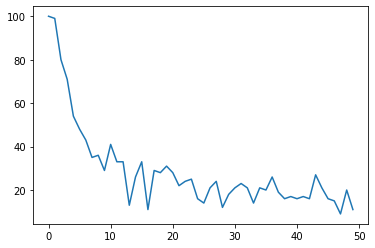

In [11]:
plt.plot(serverFA.roundClients)

In [48]:
roundClients_BS50=serverFA.roundClients

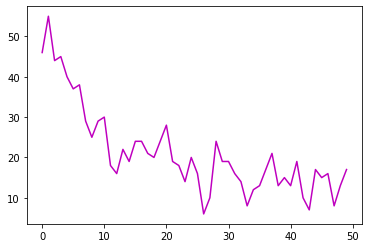

In [49]:

plt.plot(roundClients_BS50,'m')

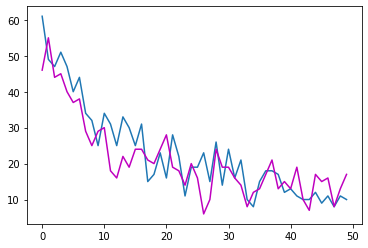

In [50]:
plt.plot(roundClients_BS20)
plt.plot(roundClients_BS50,'m')

In [ ]:
trainingName = "CIF_UE_MaxFrac0.9_C100R50" #Name of the current Training Scheme Used for Tensorboard and Saving Results
keys = ['loss','accuracy']
numberOfTraingRounds = 50
serverTestMetrics=[]*numberOfTraingRounds
logdir = "logs/" + trainingName + "/"
summary_writer = tf.summary.create_file_writer(logdir)
with summary_writer.as_default():
    for i in range(0,numberOfTraingRounds):
        serverFA.getClientActiveStatus()
        serverFA.getClientCIF()
        serverFA.getClientSelectedMaxFrac()
        serverFA.getModelUpdateFromClients()
        metrics = serverFA.testServerModel()
        d_metrics = zip(keys,metrics)
        serverTestMetrics.append(metrics)
        serverFA.updateAllClients()
        for name , value in d_metrics:
            tf.summary.scalar(name, value, step=i)


In [51]:
roundClients_BS20_20 = roundClients_BS20

In [52]:
roundClients_BS20_20[:20]

[61,
 49,
 47,
 51,
 47,
 40,
 44,
 34,
 32,
 25,
 34,
 31,
 25,
 33,
 30,
 25,
 31,
 15,
 17,
 23]

In [53]:
roundClients_BS50_20 = roundClients_BS50

In [55]:
roundClients_BS50_20[:20]

[46,
 55,
 44,
 45,
 40,
 37,
 38,
 29,
 25,
 29,
 30,
 18,
 16,
 22,
 19,
 24,
 24,
 21,
 20,
 24]

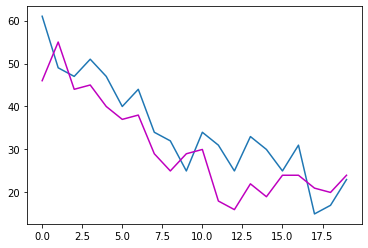

In [60]:
plt.plot(roundClients_BS20_20[:20])
plt.plot(roundClients_BS50_20[:20],'m')

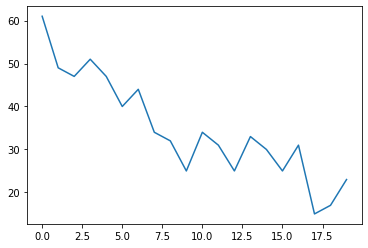

In [69]:
plt.plot(roundClients_BS20_20[:20])


In [67]:
xlabel = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]